In [47]:
import os 
import sys
from pathlib import Path
import argparse
from bs4 import BeautifulSoup
import json
import requests
import time
from datetime import datetime
import pandas as pd
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt


In [48]:
url = "https://sportsbook.draftkings.com/leagues/basketball/88670846"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")
first_lines = soup.find_all("div", class_="parlay-card-10-a")[0]
# # # soup2 =  BeautifulSoup(page.content, "html.parser")

In [49]:
# TODO: look for the tag when it's like MON JAN 10 instead of TODAY or TOMORROW
soup.find_all("div", class_="pamrlay-card-10-a")[0].find_all("span")

[<span><span><span>Today</span> </span></span>,
 <span><span>Today</span> </span>,
 <span>Today</span>,
 <span>SPREAD</span>,
 <span>TOTAL</span>,
 <span>MONEYLINE</span>,
 <span aria-label="Icon indicating a live or in-progress event" class="sportsbook__icon--live"></span>,
 <span class="event-cell__time">2:34</span>,
 <span class="event-cell__period">4th Quarter</span>,
 <span class="event-cell__name"><div class="event-cell__name-logo-wrapper"><img alt="PHO Suns-logo" class="event-cell__logo" src="https://sportsbook.draftkings.com/static/logos/teams/nba/PHX.png"/><div class="event-cell__name-text">PHO Suns</div></div><span class="event-cell__score">116</span></span>,
 <span class="event-cell__score">116</span>,
 <span class="sportsbook-odds american no-margin default-color">-6000</span>,
 <span aria-label="Icon indicating a live or in-progress event" class="sportsbook__icon--live"></span>,
 <span class="event-cell__time">2:34</span>,
 <span class="event-cell__period">4th Quarter</spa

In [134]:
# page = requests.get(url)
# soup = BeautifulSoup(page.content, "html.parser")
lines_by_day = soup.find_all("div", class_="parlay-card-10-a")
if len(lines_by_day[0].find_all("span", text="Today")) > 0: # we have lines left for today
    print("today lines")
    todays_lines = lines_by_day[0]
else: # no more lines for today (or potentially it's past midnight and the lines are listed as yesterday's) 
    hour = datetime.now().hour
    if hour < 3 and len(lines_by_day) > 1: # past midnight and we have two sections of lines
        # TODO: should replace <len(lines_by_day)> with some search for a tag that the first section is a date (representing the day that just finished)
        todays_lines = lines_by_day[0]
    else:
        print("no more lines")
        pass
    

today lines


In [135]:
lines = pd.concat([pd.read_csv("data/lines/" + file) for file in os.listdir("data/lines") if file.endswith(".csv")])

In [136]:
lines = lines.sort_values(['home', 'vis', 'home_score', 'vis_score']).dropna()

In [139]:
game_lines = lines.loc[(lines['home'] == "DET") & (lines['vis'] == "ATL")].copy(deep=True).reset_index(drop=True)
game_lines.tail()

,home,vis,home_score,vis_score,quarter,time,home_mline,vis_mline,date
36,DET,ATL,113.0,107.0,O,0:53,-120.0,-110.0,2022-03-07
37,DET,ATL,113.0,110.0,O,0:40,-120.0,-110.0,2022-03-07
38,DET,ATL,113.0,110.0,O,0:11,-120.0,-110.0,2022-03-07
39,DET,ATL,113.0,110.0,O,0:20,-120.0,-110.0,2022-03-07
40,DET,ATL,113.0,110.0,O,0:17,-120.0,-110.0,2022-03-07


In [105]:
def get_implied_prob(line):
    if line >= 100:
        return 100/(100+line)
    else:
        return (-line)/(100-line)

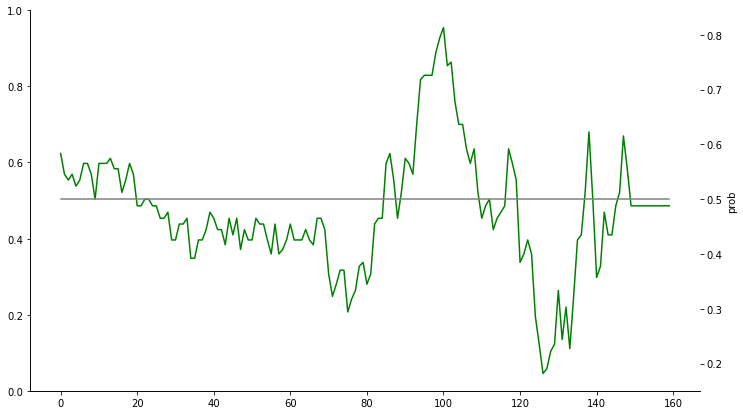

In [127]:
fig, ax = plt.subplots(figsize=(12, 7))
ax2 = ax.twinx()
game_lines['prob'] = game_lines['home_mline'].apply(get_implied_prob)
# sns.lineplot(x=game_lines.index, y=game_lines.home_mline, ax=ax)
sns.lineplot(x=game_lines.index, y=game_lines.prob, color='g', ax=ax2)
sns.lineplot(x=game_lines.index, y=0.5, color='gray', ax=ax2)
sns.despine()